# YamboWorkflow: a full DFT+MBPT flow - BSE version

In this notebook we will compute the BSE absorption spectrum and excitonic eigenvalues by means of the `YamboWorkflow` workchain of the plugin.
We are going to compute exciton starting from a scissor and stretching correction for the DFT eigenvalues. In the next tutorial we will see how to 
compute G0W0 correction in order to perform BSE@G0W0.

In [2]:
from aiida import orm, load_profile
load_profile()

from aiida.plugins import WorkflowFactory
YamboWorkflow = WorkflowFactory('yambo.yambo.yambowf')

from aiida_quantumespresso.common.types import ElectronicType

## Providing the minimal inputs needed for protocols

We have to provide minimal inputs for the creation of the builder instance, namely:
- codes;
- structure;

Providing a parent calculation as input, the already performed steps are skipped, in order to avoid waste of human and computational time.
If no parent is passed to the builder, also DFT inputs are created within the protocols as provided in the `PwBaseWorkChain`.

In [4]:
options = {
    'pwcode_id': 'pw-7.1@hydralogin', 
    'pseudo_family':"PseudoDojo/0.4/PBE/SR/standard/upf",
    'yamboprecode_id':'p2y-5.1@hydralogin',
    'yambocode_id':'yambo-5.1@hydralogin',
    'protocol':'fast',
    #'parent_id':274, #not necessary to set; take your previously nscf id (pk) to skip the DFT part.
    'structure_id':161,
}

In [7]:
builder = YamboWorkflow.get_builder_from_protocol(
            pw_code = options['pwcode_id'],
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            protocol_qe=options['protocol'],
            structure= orm.load_node(options['structure_id']),
            overrides={},
            pseudo_family= options['pseudo_family'],
            #parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
            electronic_type=ElectronicType.INSULATOR, #default is METAL: smearing is used
            calc_type='bse', #or 'bse'; default is 'gw'
)


Summary of the main inputs:
BndsRnXs = 200
NGsBlkXs = 6 Ry
BSENGBlk = 6 Ry
FFTGvecs = 18 Ry


kpoint mesh for nscf: [6, 6, 2]


With respect to the previous examples (2_YamboRestart), we can see that we have a different FFTGvecs value and a kpoint mesh: the first is due to the fact that now FFTGvecs is estimated from aiida-quantumespresso protocol, not from the previous DFT run. The second is needed in order to have also the DFT part performed, if needed (no previous parent calculations).

In [8]:
#You can also try different protocols:
    
YamboWorkflow.get_available_protocols()

{'fast': {'description': 'Under converged for most materials, but fast'},
 'moderate': {'description': 'Meta converged for most materials, higher computational cost than fast'},
 'precise': {'description': 'Converged for most materials, higher computational cost than moderate'}}

Now, if you inspect the prepopulated inputs, you can see the default values respecting the imposed protocol:

In [9]:
builder.nscf.pw.parameters.get_dict()

{'CONTROL': {'calculation': 'nscf',
  'forc_conv_thr': 0.001,
  'tprnfor': True,
  'tstress': True,
  'etot_conv_thr': 0.0004},
 'SYSTEM': {'nosym': False,
  'occupations': 'fixed',
  'ecutwfc': 60.0,
  'ecutrho': 480.0,
  'force_symmorphic': True,
  'nbnd': 200},
 'ELECTRONS': {'electron_maxstep': 80,
  'mixing_beta': 0.4,
  'conv_thr': 1.6e-09}}

In [10]:
builder.yres.yambo.parameters.get_dict()

{'arguments': ['em1s', 'bse', 'bss', 'optics', 'rim_cut', 'dipoles'],
 'variables': {'Chimod': 'hartree',
  'DysSolver': 'n',
  'GTermKind': 'BG',
  'X_and_IO_nCPU_LinAlg_INV': [1, ''],
  'BSEmod': 'resonant',
  'BSKmod': 'SEX',
  'BSSmod': 'd',
  'Lkind': 'full',
  'BSEQptR': [[1, 1], ''],
  'FFTGvecs': [18, 'Ry'],
  'GbndRnge': [[1, 200], ''],
  'BndsRnXs': [[1, 200], ''],
  'NGsBlkXs': [6, 'Ry'],
  'BSENGBlk': [6, 'Ry']}}

In [11]:
builder.scf.pw.metadata.options = {
    'max_wallclock_seconds': 60*60, # in seconds
    'resources': {
            "num_machines": 1, # nodes
            "num_mpiprocs_per_machine": 16, # MPI per nodes
            "num_cores_per_mpiproc": 1, # OPENMP
        },
    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
    #'account':'project_name',
    'queue_name':'s3par',
    #'qos':'',
}

builder.nscf.pw.metadata.options = builder.scf.pw.metadata.options
builder.yres.yambo.metadata.options = builder.scf.pw.metadata.options

### Overrides

As in the previous examples (see e.g. then  `YamboRestart` notebook), it is possible to modify the default inputs also during the builder creation phase, so not a posteriori. This can be done by using overrides:

In [15]:
overrides_scf = {
        'pseudo_family': "PseudoDojo/0.4/PBE/SR/standard/upf", 
        'pw':{
            
        'metadata':{
                    'options':{
                    'max_wallclock_seconds': 60*60, # in seconds
                    'resources': {
                            "num_machines": 1, # nodes
                            "num_mpiprocs_per_machine": 16, # MPI per nodes
                            "num_cores_per_mpiproc": 1, # OPENMP
                        },
                    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
                    #'account':'project_name',
                    'queue_name':'s3par',
                    #'qos':'',
                                    },
        },
        },
    }

overrides_nscf = {
        'pseudo_family': "PseudoDojo/0.4/PBE/SR/standard/upf", 
        'pw': {
            'parameters':{
                'CONTROL':{}, #not needed if you don't override something
                'SYSTEM':{},
                'ELECTRONS':{'diagonalization':'cg'},
            },
             'metadata':{
                    'options':{
                    'max_wallclock_seconds': 60*60, # in seconds
                    'resources': {
                            "num_machines": 1, # nodes
                            "num_mpiprocs_per_machine": 16, # MPI per nodes
                            "num_cores_per_mpiproc": 1, # OPENMP
                        },
                    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
                    #'account':'project_name',
                    'queue_name':'s3par',
                    #'qos':'',
                                    },
        },
    },
}

overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "NGsBlkXs": [4, "Ry"],
                    "BSENGBlk": [4, "Ry"],
                    "FFTGvecs": [20, "Ry"],
                },
            },
        'metadata':{
                    'options':{
                    'max_wallclock_seconds': 60*60, # in seconds
                    'resources': {
                            "num_machines": 1, # nodes
                            "num_mpiprocs_per_machine": 16, # MPI per nodes
                            "num_cores_per_mpiproc": 1, # OPENMP
                        },
                    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed, i.e. in PBS/Torque 
                    #'account':'project_name',
                    'queue_name':'s3par',
                    #'qos':'',
                                    },
                    },
        },
    
}

overrides = {
    'yres': overrides_yambo,
    'nscf': overrides_nscf,
    'scf': overrides_scf
    
}


In [16]:
builder = YamboWorkflow.get_builder_from_protocol(
            pw_code = options['pwcode_id'],
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            protocol_qe=options['protocol'],
            structure= orm.load_node(options['structure_id']),
            overrides=overrides,
            #parent_folder=load_node(options['parent_id']).outputs.remote_folder,
            electronic_type=ElectronicType.INSULATOR, #default is METAL: smearing is used
            calc_type='bse', #or 'bse'; default is 'gw'
)

Summary of the main inputs:
BndsRnXs = 200
NGsBlkXs = 4 Ry
BSENGBlk = 4 Ry
FFTGvecs = 20 Ry


kpoint mesh for nscf: [6, 6, 2]


For BSE simulation, it is important to explicitely put the parallelism instructions in the input parameters (check this).
It can be done in the overrides, or we can also re-define the variable `builder.yres.yambo.parameters`:

In [17]:
builder.yres.yambo.parameters = orm.Dict(
    dict={'arguments':['em1s','bse','bss','optics', 'dipoles',],
                'variables':{
                'BSEmod': 'resonant',
                'BSKmod': 'SEX',
                'BSSmod': 'd',
                'Lkind': 'full',
                'NGsBlkXs': [2, 'Ry'],
                'BSENGBlk': [2, 'Ry'],
                'Chimod': 'hartree',
                'DysSolver': 'n',
                'BEnSteps': [10,''],
                'BSEQptR': [[1,1],''],
                'BSEBands': [[8,9],''],
                'BEnRange': [[0.0, 10.0],'eV'],
                'BDmRange': [[0.1, 0.1],'eV'],
                'BLongDir': [[1.0, 1.0, 1.0],''],
                'LongDrXp': [[1.0, 1.0, 1.0],''],
                'LongDrXd': [[1.0, 1.0, 1.0],''],
                'LongDrXs': [[1.0, 1.0, 1.0],''],
                'BndsRnXs': [[1,50], ''],
                'KfnQP_E':[[1.5,1,1],''],           # <== Scissor and stretching correction.
                'BS_CPU':str(int(16/2))+' 2 1',     # <== PARALLELISM INFO
                'BS_ROLEs':'k eh t',                # <== PARALLELISM INFO
                },}
)

In [18]:
builder.yres.yambo.metadata.options

{'stash': {}, 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 16, 'num_cores_per_mpiproc': 1}, 'max_wallclock_seconds': 3600, 'withmpi': True, 'prepend_text': 'export OMP_NUM_THREADS=1', 'queue_name': 's3par'}

In [19]:
builder.nscf.pw.parameters.get_dict()['ELECTRONS']['diagonalization']

'cg'

In [20]:
family = orm.load_group("PseudoDojo/0.4/PBE/SR/standard/upf")
#builder.<sublevels_up_to .pw>.pseudos = family.get_pseudos(structure=structure) 
builder.scf.pw.pseudos = family.get_pseudos(structure=orm.load_node(161)) 
builder.nscf.pw.pseudos = family.get_pseudos(structure=orm.load_node(161)) 

### Requesting the YamboWorkflow to compute a specific quantity: the lowest and brightest excitons.

This is the same input that we provided in the `3_YamboWorkflow_G0W0.ipynb` tutorial, but here we ask for excitons:

In [19]:
builder.additional_parsing = orm.List(list=['lowest_exciton','brightest_exciton'])

#### Submission

In [20]:
from aiida.engine import submit

In [21]:
run = None

In [22]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

/scratch/mbonacci/mambaforge/envs/minitutorial/lib/python3.10/site-packages/aiida_quantumespresso/calculations/pw.py:211: UserWarning: `parent_folder` not provided for `nscf` calculation. For work chains wrapping this calculation, you can disable this warning by excluding the `parent_folder` when exposing the inputs of the `PwCalculation`.
  warnings.warn(


uuid: a472ba22-7c36-4752-ab9b-a98830fd3374 (pk: 2756) (aiida.workflows:yambo.yambo.yambowf)


## Inspecting the outputs

suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance. All the outputs of YamboRestart and YamboCalculation are inherited

In [22]:
run.is_finished_ok

True

In [23]:
run.outputs.output_ywfl_parameters.get_dict()

{'lowest_exciton': 5.5288767814636,
 'brightest_exciton': 11.227149963379,
 'lowest_exciton_index': 1,
 'brightest_exciton_index': 60}

In [24]:
!verdi process show {run.pk}

Property     Value
-----------  ------------------------------------
type         YamboWorkflow
state        Finished [0]
pk           2756
uuid         a472ba22-7c36-4752-ab9b-a98830fd3374
label
description
ctime        2024-01-08 21:46:56.864745+01:00
mtime        2024-01-08 21:57:59.808906+01:00

Inputs                      PK    Type
--------------------------  ----  -------------
nscf
    max_iterations          2745  Int
    kpoints                 2744  KpointsData
    kpoints_force_parity    2743  Bool
    kpoints_distance        2742  Float
    clean_workdir           2741  Bool
    pw
        parameters          2740  Dict
        structure           161   StructureData
        code                202   InstalledCode
        pseudos
            N               135   UpfData
            B               102   UpfData
scf
    max_iterations          2739  Int
    kpoints_force_parity    2738  Bool
    kpoints_distance        2737  Float
    clean_workdir           2736  Bool
   

### Plotting the BSE absorption spectrum

In [26]:
array_chi = run.outputs.array_chi

In [27]:
array_chi.get_arraynames()

['eV', 'eps_1', 'eps_2']

In [28]:
energy = array_chi.get_array("eV")
epsilon2 = array_chi.get_array("eps_2")

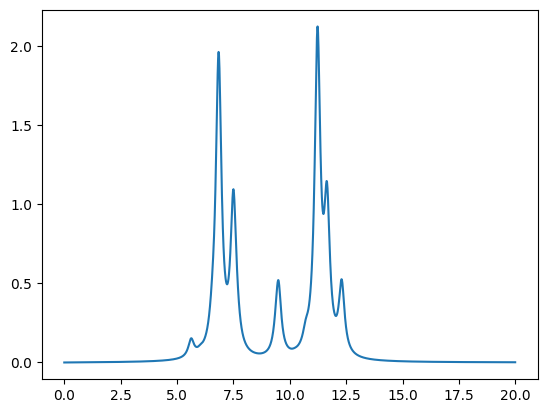

In [29]:
import matplotlib.pyplot as plt

plt.plot(energy,epsilon2)

Up to now, only the BSE absorption and loss spectra can be plotted: the RPA-IP spectra are not saved in the repository.
However, they can be easily generated using yambopy functions, once the BSE database is loaded. If you are already and expert of `yambopy`, you can try to do it by using the trick used for the ndb.QP_fixed
file.